In [1]:
# Install taming transformers if not installed yet.
# %cd taming-transformers
# pip install -e .

In [1]:
import io
import os, sys

import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np
import yaml
from omegaconf import OmegaConf
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TVF
from IPython.display import display, display_markdown
from taming.models.vqgan import VQModel, GumbelVQ


torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\computer\miniconda3\envs\torch3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config


def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()


def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x


def preprocess_vqgan2(x):
  x = 2.*x - 1.
  return x


def reconstruct_with_vqgan2(x, model):
  with torch.no_grad():
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices] = model.encode(x)
    print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    print(x.shape, z.shape, indices.shape)
    print(indices)
    xrec = model.decode(z)
    return xrec


def reconstruct_with_vqgan3(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  print(x.shape, z.shape, indices.shape)
  print(indices)

  z_courrption = torch.randn_like(z)
  z -= z_courrption

  xrec = model.decode(z)
  return xrec
  

def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TVF.resize(img, s, interpolation=PIL.Image.Resampling.LANCZOS)
    img = TVF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img


In [6]:
config32x32 = load_config("../logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
model32x32 = load_vqgan(config32x32, ckpt_path="../logs/vqgan_gumbel_f8/checkpoints/last.ckpt", is_gumbel=True).to(DEVICE)


pytorch_total_params = sum(p.numel() for p in model32x32.parameters())
print(pytorch_total_params)
pytorch_trainable_params = sum(p.numel() for p in model32x32.parameters() if p.requires_grad)
print(pytorch_trainable_params)

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
68995971
68995971


VQGAN --- GumbelVQ: latent shape: torch.Size([32, 32])
torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 32, 32]) torch.Size([1, 32, 32])
tensor([[[ 372, 5791, 3608,  ..., 3131, 8022, 4673],
         [1991,  372, 5298,  ..., 5419, 4840, 7036],
         [2130, 6561, 7080,  ..., 6561, 7307, 7036],
         ...,
         [5826, 6674, 7001,  ..., 4447,  553, 6782],
         [7557, 5610, 5499,  ..., 2736,  537, 7549],
         [4419, 2493, 2173,  ..., 4516, 5999, 7146]]], device='cuda:0')


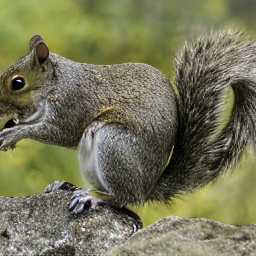

In [7]:
input_img="../logs/vqgan_gumbel_f8/imgs/0810.png"


input_img = Image.open(input_img)
# target_image_size = 384
target_image_size = 256
x_vqgan = preprocess(input_img, target_image_size=target_image_size)
x_vqgan = x_vqgan.to(DEVICE)

# 8x spatial dimension reduction log_2(8) times divide h, w by 2.
# x0 = reconstruct_with_vqgan3(preprocess_vqgan2(x_vqgan), model32x32)
x0 = reconstruct_with_vqgan2(preprocess_vqgan2(x_vqgan), model32x32)
w, h = target_image_size, target_image_size

x0 = custom_to_pil(x0[0])
# x0 = custom_to_pil(x0[0])
img = Image.new("RGB", (w, h))
img.paste(x0, (0,0))

display(img)